In [132]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

### 1050 Ti

In [18]:
peak_throughput = 2809.313
peak_DRAM_BW = 100.675
peak_L2_BW = 692.587

In [166]:
# Utility functions
def abs_err(pred, real):
    return abs((pred - real) / real)

def gmae(x):
    return np.exp(np.log(abs(x)).mean())

def histogram(df, perc=True, bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0]):
    count = len(df)
    ret = {}
    for idx, b in enumerate(bins):
        if idx == 0:
            continue
        ret[(bins[idx-1], bins[idx])] = 0
    for x in df:
        for idx, b in enumerate(bins):
            if idx == 0:
                continue
            if x >= bins[idx-1] and x < bins[idx]:
                ret[(bins[idx-1], bins[idx])] += 1
                break
    for b, c in sorted(ret.items(), key=lambda x: x[0]):
        if perc:
            print("{:.0f}% - {:.0f}%: {:.2f}%".format(b[0] * 100, b[1] * 100, c / count * 100))
        else:
            print("{:.0f} - {:.0f}: {:.2f}%".format(b[0], b[1], c / count * 100))
    return ret
    
    

def strip_unit(x):
    for col in ['dram_read_throughput', 'dram_write_throughput', 'gld_requested_throughput', 'gld_throughput',\
               'gst_requested_throughput', 'gst_throughput', 'l2_read_throughput', 'l2_write_throughput', \
                'shared_load_throughput', 'shared_store_throughput']:
        if x[col].endswith('GB/s'):
            x[col] = float(x[col].rstrip('GB/s'))
        elif x[col].endswith('MB/s'):
            x[col] = float(x[col].rstrip('MB/s')) / 1e3
        elif x[col].endswith('B/s'):
            x[col] = float(x[col].rstrip('B/s')) / 1e9
        else:
            raise Exception("Unrecognizable unit!")
    return x
    
def p2f(x):
    for col in ['flop_dp_efficiency', 'flop_sp_efficiency', 'gld_efficiency', 'gst_efficiency', \
                'shared_efficiency', 'sm_efficiency', 'warp_execution_efficiency']:
        x[col] = float(x[col].rstrip('%')) / 100.0
    return x

def strip_parenthesis(x):
    for col in ['dram_utilization', 'l2_utilization', 'tex_utilization']:
        x[col] = x[col].strip('(').strip(')')
    return x
        
def preprocessing(df):
    df = df.apply(func=p2f, axis=1)
    df = df.apply(func=strip_unit, axis=1)
    df = df.apply(func=strip_parenthesis, axis=1)
    return df

### Concat

In [142]:
concat_data = pd.read_csv('./data/concat_1_results.csv', delimiter=',')
concat_data = preprocessing(concat_data)
concat_data.head()

,kernel_name,batch_size,M,N,K,kernel_runtime,op_runtime,achieved_occupancy,dram_read_throughput,dram_write_throughput,dram_read_transactions,dram_write_transactions,dram_utilization,flop_count_dp,flop_count_dp_add,flop_count_dp_fma,flop_count_dp_mul,flop_dp_efficiency,flop_count_sp,flop_count_sp_add,flop_count_sp_fma,flop_count_sp_mul,flop_count_sp_special,flop_sp_efficiency,gld_efficiency,gld_requested_throughput,gld_throughput,gld_transactions,gld_transactions_per_request,gst_efficiency,gst_requested_throughput,gst_throughput,gst_transactions,gst_transactions_per_request,inst_compute_ld_st,inst_control,inst_executed,inst_fp_32,inst_fp_64,inst_integer,inst_issued,inst_misc,inst_per_warp,ipc,ipc_instance,l2_read_throughput,l2_read_transactions,l2_write_throughput,l2_write_transactions,l2_utilization,shared_efficiency,shared_load_throughput,shared_load_transactions,shared_store_throughput,shared_store_transactions,sm_efficiency,tex_utilization,warp_execution_efficiency
0,CatArrayBatchedCopy,1,64,1,15,3.168,45,0.740514,0.3486,0.4621,32,42,0,0,0,0,0,0.0,0,0,0,0,1950,0.0,0.3264,1.9568,5.9958,8586,18.000000,0.9990,1.2865,1.2878,122,3.935484,16188,12288,11195,1950,0,248208.0,11963,66315,29.153646,1.243151,NaN,6.9248,656,1.4251,135,1,0.0,0.0,0,0.0,0,0.2961,1,0.9952
1,CatArrayBatchedCopy,1,64,1,64,2.784,45,0.671025,2.7621,2.5203,291,265,1,0,0,0,0,0.0,0,0,0,0,8320,0.0,0.5438,6.0031,11.0390,16546,21.377261,1.0000,4.9315,4.9315,520,4.000000,28928,12288,21194,8320,0,496638.0,21962,82240,55.192708,1.490114,NaN,12.4140,1309,5.0548,533,1,0.0,0.0,0,0.0,0,0.4297,1,1.0000
2,CatArrayBatchedCopy,1,64,1,197,3.264,44,0.635279,3.2005,4.7699,416,620,1,0,0,0,0,0.0,0,0,0,0,12682,0.0,0.7336,13.4490,18.3330,25258,21.350803,0.9998,12.3140,12.3170,1601,3.992519,50580,18752,41091,12682,0,1015812.0,41859,99609,107.007812,2.223556,NaN,19.2260,2499,12.4170,1614,1,0.0,0.0,0,0.0,0,0.4826,1,0.9979
3,CatArrayBatchedCopy,1,64,1,256,3.680,47,0.635174,3.8698,3.2970,538,459,1,0,0,0,0,0.0,0,0,0,0,12800,0.0,0.7779,16.0040,20.5720,27266,20.909509,1.0000,14.9410,14.9410,2080,4.000000,58368,22528,48744,12800,0,1224318.0,49512,103680,126.937500,2.347864,NaN,21.7290,3025,15.0340,2093,1,0.0,0.0,0,0.0,0,0.5113,1,1.0000
4,CatArrayBatchedCopy,1,64,1,512,4.243,47,0.589177,11.5830,8.4798,2107,1542,2,0,0,0,0,0.0,0,0,0,0,13312,0.0,0.8694,23.7010,27.2630,36098,19.618478,1.0000,22.8660,22.8660,4160,4.000000,92160,38912,82320,13312,0,2129022.0,83088,121344,214.375000,2.640953,NaN,27.9770,5090,22.9370,4173,1,0.0,0.0,0,0.0,0,0.6077,1,1.0000


In [156]:
A_size = concat_data["batch_size"] * concat_data["M"] * concat_data["K"]
B_size = concat_data["batch_size"] * concat_data["N"] * concat_data["K"]
total_traffic = 2 * (A_size + B_size) * 4

In [168]:
estimated_time = total_traffic / peak_DRAM_BW / 1000
error = abs_err(estimated_time, concat_data['kernel_runtime'])
histogram(error)
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))

0% - 5%: 0.06%
5% - 10%: 27.91%
10% - 15%: 50.26%
15% - 20%: 10.09%
20% - 25%: 4.73%
25% - 30%: 1.98%
30% - 40%: 0.77%
40% - 50%: 0.89%
50% - 60%: 0.51%
60% - 80%: 1.85%
80% - 100%: 0.96%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
GMAE: 12.66%, mean: 14.72%, std: 12.22%


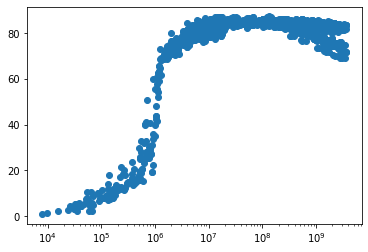

In [155]:
fig = plt.figure()
ax = plt.gca()
plt.scatter(total_traffic, concat_data["dram_read_throughput"] + concat_data["dram_write_throughput"])
ax.set_xscale('log')

In [160]:
actual_peak_DRAM_BW = max(concat_data["dram_read_throughput"] + concat_data["dram_write_throughput"])
actual_peak_DRAM_BW

87.31299999999999

In [167]:
estimated_time = total_traffic / actual_peak_DRAM_BW / 1000
error = abs_err(estimated_time, concat_data['kernel_runtime'])
histogram(error)
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))

0% - 5%: 69.92%
5% - 10%: 20.50%
10% - 15%: 2.94%
15% - 20%: 1.85%
20% - 25%: 0.13%
25% - 30%: 0.38%
30% - 40%: 0.83%
40% - 50%: 0.57%
50% - 60%: 0.64%
60% - 80%: 1.34%
80% - 100%: 0.89%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
GMAE: 3.30%, mean: 6.54%, std: 12.63%
